In [ ]:
## importing thư viện
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
import cv2
# Thư viện về thị giác máy tính
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import *
from scipy import ndimage
from skimage.color import rgb2gray
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, Reshape,Conv2DTranspose
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils
from keras import backend as K

In [ ]:
ndef rgb2gray (rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()
# input image dimensions
print("Shape of the Training Images: ", x_train.shape)
print("Shape of the Test Images: ", x_test.shape)
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

170498071/170498071 [==============================] - 22s 0us/step
Shape of the Training Images:  (50000, 32, 32, 3)
Shape of the Test Images:  (10000, 32, 32, 3)


In [ ]:
#@title Văn bản tiêu đề mặc định
#Tạo folder lưu ảnh có tên saved_images
imgs_dir = "saved_images"
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

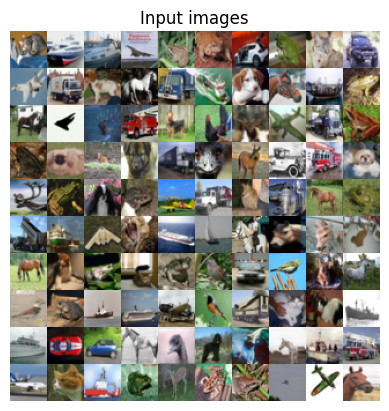

In [ ]:
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input images')
plt.imshow(imgs)
plt.savefig("%s/test_color.png" %imgs_dir)
plt.show()

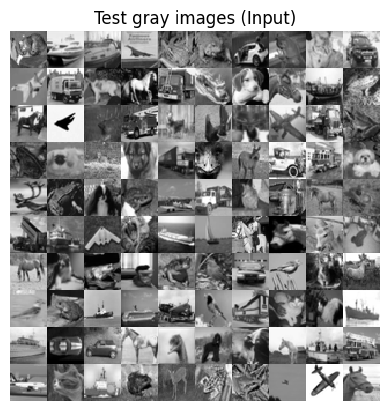

In [ ]:
x_train_gray = rgb2gray (x_train)
x_test_gray = rgb2gray(x_test)
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title("Test gray images (Input)")
plt.imshow(imgs, interpolation='none', cmap="gray")
plt.savefig("%s/test_gray.png" % imgs_dir)
plt.show()

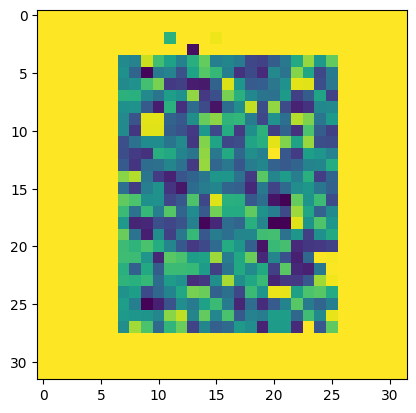

In [ ]:
import cv2

# Input ảnh
input_ing = cv2.imread("/content/saved_images/test_gray.png", cv2.IMREAD_GRAYSCALE)

# Thay đổi kích thước thành (32,32)
resized_img = cv2.resize(input_ing,(32,32),fx=0,fy=0)
resized_ing = resized_img.reshape((1, 32, 32, 1))
plt.imshow(resized_img)

In [ ]:
# Chuẩn hóa đầu ra và kiểm tra hình ảnh
x_train = x_train.astype('float32') / 255

x_test = x_test.astype('float32') / 255

# chuẩn hóa ảnh vào và kiểm tra hình ảnh thang độ xám
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255
# định hình lại hình ảnh thành hàng x cột x kênh cho đầu ra cho mạng nơ-ron
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
#định hình lại hình ảnh thành hàng x cột x kênh cho đầu vào mạng nơ-ron
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)


In [ ]:
input_shape = (img_rows, img_cols, 1)
batch_size = 16
kernel_size = 3
latent_dim = 256
# encoder/decoder number của lớp mạng và bộ lọc trên mỗi lớp
layer_filters = [64, 128, 256]
# xây dựng mô hình mã hóa tự động
# đầu tiên xây dựng mô hình bộ mã hóa
inputs = Input(shape = input_shape, name = "encoder_input")
x = inputs
# stack of Conv20(64)-Conv20(128)-Conv20(256)
for filters in layer_filters:
    x = Conv2D(filters = filters,
                kernel_size = kernel_size,
                strides = 2,
                activation = "relu",
                padding = "same")(x)
shape = K.int_shape(x)
shape


(None, 4, 4, 256)

In [ ]:
x = Flatten()(x)
latent = Dense(latent_dim, name = "latent_vector")(x)
# khởi tạo encoder model
encoder = Model(inputs, latent, name = "encoder")
encoder.summary()
# dựng decoder model
latent_inputs = Input(shape = (latent_dim,), name= "decoder_input")
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stack of Conv20Transpose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        strides = 2,
                        activation = "relu",
                        padding = "same")(x)
outputs = Conv2DTranspose(filters = channels,
                          kernel_size = kernel_size,
                          activation = "sigmoid",
                          padding = "same",
                          name = "decoder_output")(x)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)       7379

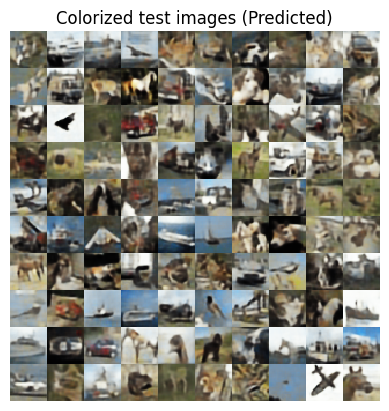

In [ ]:
# khởi tạo decoder model
decoder = Model(latent_inputs, outputs, name= "decoder")
decoder.summary()

# khởi tạo autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)),name = "autoencoder")
autoencoder.summary()

save_dir = os.path.join(os.getcwd(), "saved_models")
model_name = "colorized_ae_model.{epoch:03d}.h5"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),
                               cooldown = 0,
                               patience = 5,
                               verbose = 1,
                               min_lr = 1.5*0.5e-6)
#save lưu lại thông số để huấn luyện
checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = "val_loss",
                             verbose = 1,
                             save_best_only = True)
autoencoder.compile(loss="mse", optimizer = "adam")
# gọi mọi thời điểm
callbacks = [lr_reducer, checkpoint]
# train cho bộ mã hóa tự động (autoencoder)
autoencoder.fit(x_train_gray,
                x_train,
                validation_data = (x_test_gray, x_test),
                epochs = 15,
                batch_size = batch_size,
                callbacks = callbacks)
# Dự đoán đầu ra bộ mã hóa tự động từ dữ liệu thử nghiệm
x_decoded = autoencoder.predict(x_test_gray)
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis("off")
plt.title("Colorized test images (Predicted)")
plt.imshow(imgs, interpolation="none")
plt.savefig("%s/colorized.png" %imgs_dir)
plt.show()